In [0]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import os
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


In [3]:
#这批数据的最后一行都是空
data_dir = '/drive/My Drive/python_deep_learning/data/price-volume-data-for-all-us-stocks-etfs/Stocks'
fname = os.path.join(data_dir, 'ibm.us.txt')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
#最后一列的openint忽略掉
header = lines[0].split(',')[:-1]
lines = lines[1:-1]

print(header)
print(lines[0])
print(lines[-1])
print(len(lines))

['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
1962-01-02,6.413,6.413,6.3378,6.3378,467056,0
2017-11-10,150.65,150.89,149.14,149.16,4306433,0
14059


In [0]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:-1]]
    if len(values)==len(header)-1:
        float_data[i, :] = values
    else:
        print(i)

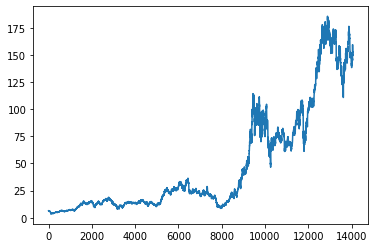

In [5]:
#求最高和最低的均值
temp = float_data[:, 1:3]
temp = temp.mean(axis = 1)
# print(temp[0])
plt.plot(range(len(temp)), temp)
plt.show()

美股一年约有255个交易日，采用过去3个月的交易记录，预测未来1天的数据，频率为每个交易日

使用前11,200‬个交易日的数据作为训练，约为前44年

In [6]:
lookback = 60
step = 1
delay = 0
batch_size = 128

# from sklearn.preprocessing import MinMaxScaler
# sc = MinMaxScaler(feature_range = (0, 1))
# real_stock_price = sc.fit_transform((float_data[:,2:4].mean(axis = 1)).reshape(-1, 1))

#标准化
mean = float_data[:11200].mean(axis=0)
float_data -= mean
std = float_data[:11200].std(axis=0)
float_data /= std
print(float_data.shape)

(14059, 5)


In [0]:
#数据样本生成器
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=1):
    """
    data: 数据，已标准化
    lookback：输入数据包含多少过去时间步
    delay：目标在未来多少时间步
    min_index和max_index: 索引，界定时间步
    step：采样频率，默认每个交易日
    """    
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay, 2:4].mean(axis=0)
        yield samples, targets

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (12609 - 11201 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 12609 - lookback) // batch_size

In [0]:
train_gen = generator(float_data,
            lookback=lookback,
            delay=delay,
            min_index=0,
            max_index=11200,
            shuffle=True,
            step=step, 
            batch_size=batch_size)
val_gen = generator(float_data,
          lookback=lookback,
          delay=delay,
          min_index=11201,
          max_index=12609,
          step=step,
          batch_size=batch_size)
test_gen = generator(float_data,
            lookback=lookback,
            delay=delay,
            min_index=12609,
            max_index=None,
            step=step,
            batch_size=batch_size)

对照组，用昨天的数据来作为今天的预估，预测值与实际值相差约1.08美元

In [10]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1:3].mean(axis = 1)
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes) * (std[2:4].mean(axis=0)))
    print(np.mean(batch_maes))
    
evaluate_naive_method()

1.0851057598934697
0.04324845597295869


简单的小型全连接层模型

In [14]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
            steps_per_epoch=500,
            epochs=20,
            validation_data=val_gen,
            validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
500/500 [==============================] - 4s 7ms/step - loss: 0.2596 - val_loss: 0.4275
Epoch 2/20
500/500 [==============================] - 3s 7ms/step - loss: 0.1709 - val_loss: 0.8695
Epoch 3/20
500/500 [==============================] - 3s 7ms/step - loss: 0.1256 - val_loss: 0.5372
Epoch 4/20
500/500 [==============================] - 3s 7ms/step - loss: 0.0936 - val_loss: 0.1009
Epoch 5/20
500/500 [==============================] - 4s 7ms/step - loss: 0.0699 - val_loss: 0.3650
Epoch 6/20
500/500 [==============================] - 3s 7ms/step - loss: 0.0547 - val_loss: 0.0834
Epoch 7/20
500/500 [==============================] - 3s 7ms/step - loss: 0.0448 - val_loss: 0.1352
Epoch 8/20
500/500 [==============================] - 3s 7ms/step - loss: 0.0403 - val_loss: 0.3547
Epoch 9/20
500/500 [==============================] - 3s 7ms/step - loss: 0.0370 - val_loss: 0.1983
Epoch 10/20
500/500 [===

结果不如对照组

In [0]:
def show_result(model, history, generater, steps):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

  result = model.evaluate(generater,steps=steps)

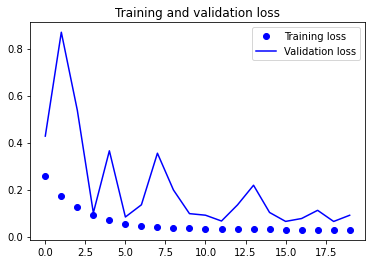

10/10 [==============================] - 0s 6ms/step - loss: 0.0907


In [16]:
val_gen = generator(float_data,lookback=lookback,delay=delay,min_index=11201,max_index=12609,step=step,batch_size=batch_size)
show_result(model, history, val_gen, val_steps)

反归一化，计算误差

In [0]:
def compare_result(predicted_stock_price,real_stock_price):
  plt.plot(real_stock_price, color = 'black', label = 'TATA Stock Price')
  plt.plot(predicted_stock_price, color = 'green', label = 'Predicted TATA Stock Price')
  plt.title('TATA Stock Price Prediction')
  plt.xlabel('Time')
  plt.ylabel('TATA Stock Price')
  plt.legend()
  plt.show()

  # calculate MSE 均方误差
  mse=mean_squared_error(real_stock_price,predicted_stock_price)
  # calculate RMSE 均方根误差
  rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
  #calculate MAE 平均绝对误差
  mae=mean_absolute_error(real_stock_price,predicted_stock_price)
  #calculate R square
  r_square=r2_score(real_stock_price,predicted_stock_price)
  print('均方误差: %.6f' % mse)
  print('均方根误差: %.6f' % rmse)
  print('平均绝对误差: %.6f' % mae)
  print('R_square: %.6f' % r_square)

##########################################################################问题很大##########################################################################
val_gen = generator(float_data,lookback=lookback,delay=delay,min_index=11201,max_index=12609,step=step,batch_size=batch_size)
stock_price = []
for i in range(val_steps):
  stock_price.append(np.array((next(val_gen))[1]))

stock_price = np.array(stock_price)
stock_price = stock_price.reshape(-1,1)
stock_price = stock_price * (std[2:4].mean(axis=0))

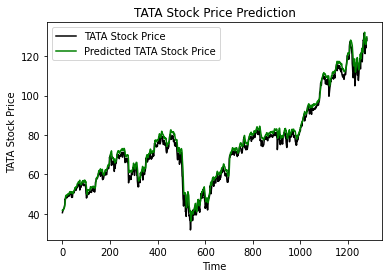

均方误差: 8.557700
均方根误差: 2.925355
平均绝对误差: 2.274984
R_square: 0.981330


In [18]:
#重置迭代器
val_gen = generator(float_data,lookback=lookback,delay=delay,min_index=11201,max_index=12609,step=step,batch_size=batch_size)
predicted_stock_price = model.predict(val_gen,steps=val_steps)
predicted_stock_price = predicted_stock_price * (std[2:4].mean(axis=0))

compare_result(predicted_stock_price,stock_price)

**使用GRU**

In [19]:
train_gen = generator(float_data,
            lookback=lookback,
            delay=delay,
            min_index=0,
            max_index=11200,
            shuffle=True,
            step=step, 
            batch_size=batch_size)
val_gen = generator(float_data,
          lookback=lookback,
          delay=delay,
          min_index=11201,
          max_index=12609,
          step=step,
          batch_size=batch_size)

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                steps_per_epoch=500,
                epochs=20,
                validation_data=val_gen,
                validation_steps=val_steps)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                3744      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,777
Trainable params: 3,777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 19s 38ms/step - loss: 0.0377 - val_loss: 0.1607
Epoch 2/20
500/500 [==============================] - 18s 36ms/step - loss: 0.0222 - val_loss: 0.1554
Epoch 3/20
500/500 [==============================] - 18s 36ms/step - loss: 0.0205 - val_loss: 0.1197
Epoch 4/20
500/500 [==============================] - 18s 36ms/step - loss: 0.0192 - val_loss: 0.0914
Epoch 5/20
500/500 [==============================] - 21s 41ms/step - loss: 0.0180 - val_loss: 0.0908
Epoc

可以看到，结果好于直接预测

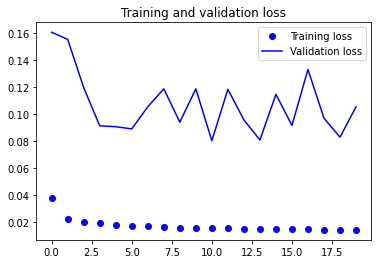

10/10 [==============================] - 0s 11ms/step - loss: 0.1055


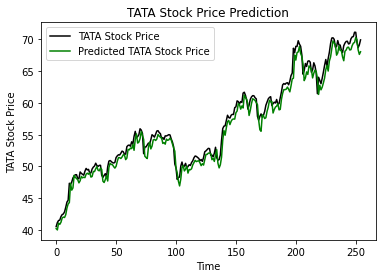

均方误差: 1.358872
均方根误差: 1.165707
平均绝对误差: 0.969528
R_square: 0.975904


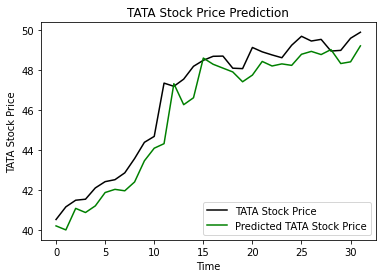

均方误差: 0.892958
均方根误差: 0.944965
平均绝对误差: 0.766597
R_square: 0.907895


In [20]:
val_gen = generator(float_data,lookback=lookback,delay=delay,min_index=11201,max_index=12609,step=step,batch_size=batch_size)
show_result(model, history, val_gen, val_steps)

val_gen = generator(float_data,lookback=lookback,delay=delay,min_index=11201,max_index=12609,step=step,batch_size=batch_size)
predicted_stock_price = model.predict(val_gen,steps=val_steps)
predicted_stock_price = predicted_stock_price * (std[2:4].mean(axis=0))
compare_result(predicted_stock_price[:255],stock_price[:255])
compare_result(predicted_stock_price[:32],stock_price[:32])
# show_result(model, history, val_gen, val_steps)

假设对股票的估计可信

In [22]:
def compare_gain(predicted_stock_price,stock_price):
  real_gain = stock_price[-1] - stock_price[0]

  #第一天买入股票
  predict_gain = 0
  for i in range(1, len(stock_price)):
    if predicted_stock_price[i] > predicted_stock_price[i-1]:
      predict_gain += stock_price[i] - stock_price[i-1]

  print("预测价格获得收益为：%f"%predict_gain)
  print("参照收益为: %f"%real_gain)

print("持股一年")
compare_gain(predicted_stock_price[:255],stock_price[:255])
print("********************************")
print("持股多年")
compare_gain(predicted_stock_price,stock_price)

持股一年
预测价格获得收益为：42.941988
参照收益为: 29.408734
********************************
持股多年
预测价格获得收益为：180.578856
参照收益为: 87.384688


**使用LSTM**

In [0]:
train_gen = generator(float_data,
            lookback=lookback,
            delay=delay,
            min_index=0,
            max_index=11200,
            shuffle=True,
            step=step, 
            batch_size=batch_size)
val_gen = generator(float_data,
          lookback=lookback,
          delay=delay,
          min_index=11201,
          max_index=12609,
          step=step,
          batch_size=batch_size)

model = Sequential()
model.add(layers.LSTM(32,input_shape=(None, float_data.shape[-1])))
# model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()
history = model.fit(train_gen,
                steps_per_epoch=500,
                epochs=20,
                validation_data=val_gen,
                validation_steps=val_steps)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 23s 46ms/step - loss: 0.0482 - val_loss: 0.7744
Epoch 2/20
500/500 [==============================] - 22s 45ms/step - loss: 0.0271 - val_loss: 0.7060
Epoch 3/20
500/500 [==============================] - 22s 45ms/step - loss: 0.0227 - val_loss: 0.5103
Epoch 4/20
500/500 [==============================] - 22s 45ms/step - loss: 0.0202 - val_loss: 0.5346
Epoch 5/20
500/500 [==============================] - 22s 45ms/step - loss: 0.0189 - val_loss: 0.4892
Epo

明显过拟合

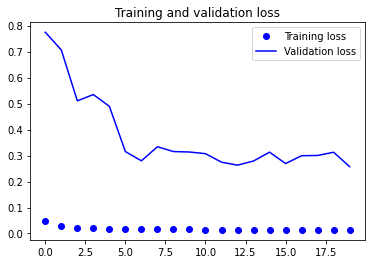

10/10 [==============================] - 0s 18ms/step


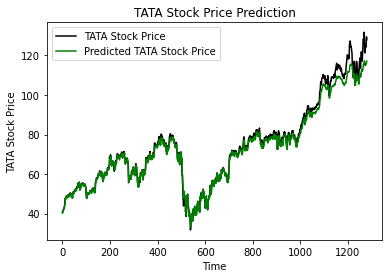

均方误差: 8.382434
均方根误差: 2.895243
平均绝对误差: 1.931452
R_square: 0.981712


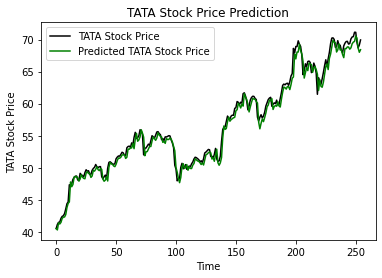

均方误差: 0.853733
均方根误差: 0.923977
平均绝对误差: 0.699620
R_square: 0.984862


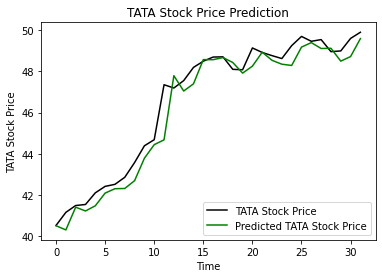

均方误差: 0.463982
均方根误差: 0.681162
平均绝对误差: 0.475554
R_square: 0.952142


In [0]:
val_gen = generator(float_data,lookback=lookback,delay=delay,min_index=11201,max_index=12609,step=step,batch_size=batch_size)
show_result(model, history, val_gen, val_steps)

val_gen = generator(float_data,lookback=lookback,delay=delay,min_index=11201,max_index=12609,step=step,batch_size=batch_size)
predicted_stock_price = model.predict(val_gen,steps=val_steps)
predicted_stock_price = predicted_stock_price * (std[2:4].mean(axis=0))
compare_result(predicted_stock_price,stock_price)
compare_result(predicted_stock_price[:255],stock_price[:255])
compare_result(predicted_stock_price[:32],stock_price[:32])

防止过拟合，添加droupout

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(32))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(learning_rate=2e-4), loss='mae')
history = model.fit_generator(train_gen,
                steps_per_epoch=500,
                epochs=40,
                validation_data=val_gen,
                validation_steps=val_steps)

In [0]:
val_gen = generator(float_data,lookback=lookback,delay=delay,min_index=11201,max_index=12609,step=step,batch_size=batch_size)
show_result(model, history, val_gen, val_steps)

val_gen = generator(float_data,lookback=lookback,delay=delay,min_index=11201,max_index=12609,step=step,batch_size=batch_size)
predicted_stock_price = model.predict(val_gen,steps=val_steps)
predicted_stock_price = predicted_stock_price * (std[2:4].mean(axis=0))
compare_result(predicted_stock_price,stock_price)
compare_result(predicted_stock_price[:255],stock_price[:255])
compare_result(predicted_stock_price[:32],stock_price[:32])

**双向LSTM**

In [0]:
train_gen = generator(float_data,
            lookback=lookback,
            delay=delay,
            min_index=0,
            max_index=11200,
            shuffle=True,
            step=step, 
            batch_size=batch_size)
val_gen = generator(float_data,
          lookback=lookback,
          delay=delay,
          min_index=11201,
          max_index=12609,
          step=step,
          batch_size=batch_size)

model = Sequential()
model.add(layers.Bidirectional(layers.LSTM(32)))
# model.add(layers.LSTM(32,input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
# model.build(train_gen)
# model.summary()
history = model.fit(train_gen,
                steps_per_epoch=500,
                epochs=20,
                validation_data=val_gen,
                validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 30s 59ms/step - loss: 0.0579 - val_loss: 0.2144
Epoch 2/20
500/500 [==============================] - 28s 57ms/step - loss: 0.0307 - val_loss: 0.2040
Epoch 3/20
500/500 [==============================] - 30s 59ms/step - loss: 0.0252 - val_loss: 0.1375
Epoch 4/20
500/500 [==============================] - 29s 59ms/step - loss: 0.0222 - val_loss: 0.1153
Epoch 5/20
500/500 [==============================] - 29s 59ms/step - loss: 0.0206 - val_loss: 0.1165
Epoch 6/20
500/500 [==============================] - 29s 58ms/step - loss: 0.0193 - val_loss: 0.1025
Epoch 7/20
500/500 [==============================] - 29s 58ms/step - loss: 0.0182 - val_loss: 0.1014
Epoch 8/20
500/500 [==============================] - 32s 64ms/step - loss: 0.0176 - val_loss: 0.1453
Epoch 9/20
500/500 [==============================] - 29s 58ms/step - loss: 0.0171 - val_loss: 0.1238
Epoch 10/20
500/500 [==============================] - 29s 58ms/step - loss: 0.016

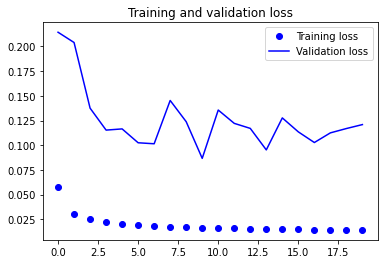

10/10 [==============================] - 0s 21ms/step - loss: 0.1209


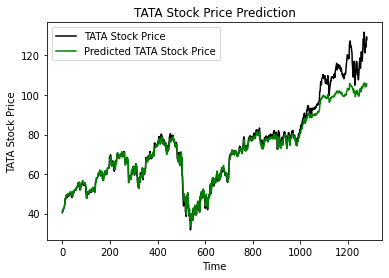

均方误差: 29.872545
均方根误差: 5.465578
平均绝对误差: 3.032845
R_square: 0.934828


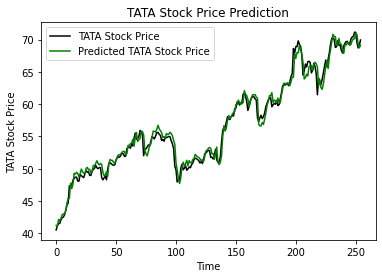

均方误差: 0.924871
均方根误差: 0.961702
平均绝对误差: 0.719058
R_square: 0.983600


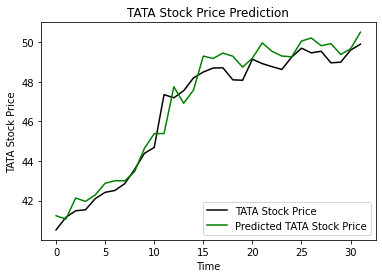

均方误差: 0.461446
均方根误差: 0.679298
平均绝对误差: 0.556824
R_square: 0.952404


In [0]:
val_gen = generator(float_data,lookback=lookback,delay=delay,min_index=11201,max_index=12609,step=step,batch_size=batch_size)
show_result(model, history, val_gen, val_steps)

val_gen = generator(float_data,lookback=lookback,delay=delay,min_index=11201,max_index=12609,step=step,batch_size=batch_size)
predicted_stock_price = model.predict(val_gen,steps=val_steps)
predicted_stock_price = predicted_stock_price * (std[2:4].mean(axis=0))
compare_result(predicted_stock_price,stock_price)
compare_result(predicted_stock_price[:255],stock_price[:255])
compare_result(predicted_stock_price[:32],stock_price[:32])

多层堆叠

In [0]:
train_gen = generator(float_data,
            lookback=lookback,
            delay=delay,
            min_index=0,
            max_index=11200,
            shuffle=True,
            step=step, 
            batch_size=batch_size)
val_gen = generator(float_data,
          lookback=lookback,
          delay=delay,
          min_index=11201,
          max_index=12609,
          step=step,
          batch_size=batch_size)

model = Sequential()
model.add(layers.Bidirectional(layers.LSTM(32,input_shape=(None, float_data.shape[-1]))))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
# model.summary()
history = model.fit(train_gen,
                steps_per_epoch=500,
                epochs=20,
                validation_data=val_gen,
                validation_steps=val_steps)

RuntimeError: ignored

后续思路：向量化表示每日每支股票信息，主成分分析降维